In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys

# Machine Learning utilities
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Suppress TF logs before TensorFlow loads
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Redirect STDERR temporarily
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

# Now import TensorFlow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Deep Learning libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.metrics import AUC

from sklearn.metrics import roc_curve, auc
import seaborn as sns
from matplotlib.cm import get_cmap

from tensorflow.keras.models import Model

import cv2
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from PIL import Image
import warnings 
warnings.filterwarnings('ignore')

E0000 00:00:1752937304.658210      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752937304.731529      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [2]:
# directory
train_ds = '/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/train'
test_ds = '/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test'

img = [name for name in os.listdir(train_ds) if os.path.isdir(os.path.join(train_ds, name))]
img

print(os.listdir("/kaggle/input/"))
print(os.listdir("/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest"))

['tea-leaves-pest-dataset']
['test', 'train']


In [3]:
# Detect dataset structure
dataset_root = "/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset"
subdirs = os.listdir(dataset_root)
print("Dataset structure:", subdirs)

# Determine if 'pest/' is required
if "pest" in subdirs:
    dataset_root = os.path.join(dataset_root, "pest")

# Now proceed with loading the images
data_dirs = ["train", "test"]
labels = os.listdir(os.path.join(dataset_root, "train"))  # Auto-detect labels

image_data, label_data = [], []
image_size = 150

for data_dir in data_dirs:
    print(f"📂 Processing '{data_dir}' directory...")
    
    for label_idx, label in enumerate(labels):
        data_path = os.path.join(dataset_root, data_dir, label)

        if not os.path.exists(data_path):
            print(f"⚠️ Warning: Missing directory - {data_path}")
            continue

        for img_file in os.listdir(data_path):
            img_path = os.path.join(data_path, img_file)
            image = cv2.imread(img_path)

            if image is None:
                print(f"❌ Skipping corrupted file: {img_path}")
                continue

            image = cv2.resize(image, (image_size, image_size))
            image_data.append(image)
            label_data.append(label_idx)

print(f"\n✅ Data processing complete! Loaded {len(image_data)} images.")

Dataset structure: ['pest']
📂 Processing 'train' directory...
📂 Processing 'test' directory...

✅ Data processing complete! Loaded 3600 images.


In [4]:
image_data, label_data = shuffle(image_data, label_data, random_state=42)
image_data = np.array(image_data, dtype=np.float32) / 255.0
label_data = np.array(label_data, dtype=np.int32)  
X_train, X_test, Y_train, Y_test = train_test_split(image_data, label_data, test_size=0.2, random_state=42)

print(f"✅ Data ready for training! Training samples: {len(X_train)}, Test samples: {len(X_test)}")

✅ Data ready for training! Training samples: 2880, Test samples: 720


nematode: 300 images
tea-mosquito-bug: 300 images
caterpillar: 300 images
leafworm: 300 images
grub: 300 images
borer: 300 images
mite: 300 images
thrip: 300 images
tea-aphid: 300 images
termite: 300 images
Total images are 3000


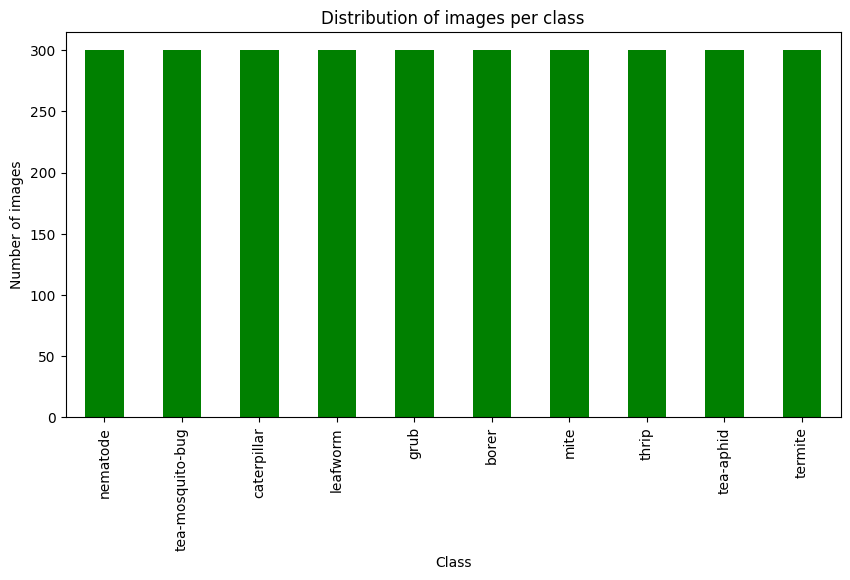

In [5]:
# label of images
classes = os.listdir(train_ds)

# Count the number of images in each class
image_counts = {cls: len(os.listdir(os.path.join(train_ds, cls))) for cls in classes}
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")
total = sum(image_counts.values())
print(f"Total images are {total}")

from matplotlib import pyplot as plt

# Plotting the distribution of images
plt.figure(figsize=(10, 5))
pd.Series(image_counts).plot(kind='bar', color='g')
plt.title('Distribution of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

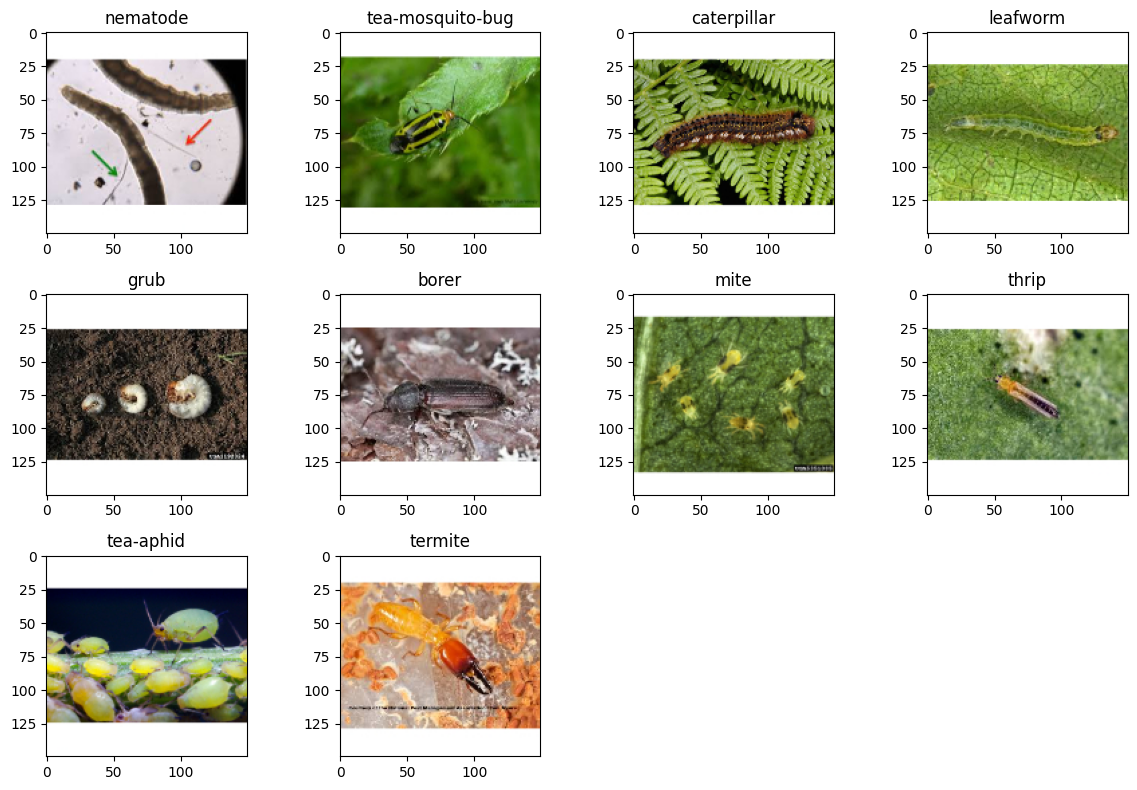

In [6]:
plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_ds, cls)
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [7]:
Y_train = np.array(Y_train, dtype=np.int32)
Y_test = np.array(Y_test, dtype=np.int32)

Y_train = to_categorical(Y_train, num_classes=len(labels))
Y_test = to_categorical(Y_test, num_classes=len(labels))

print(f"✅ Labels converted to one-hot encoding. Shape: {Y_train.shape}")

✅ Labels converted to one-hot encoding. Shape: (2880, 10)


In [8]:
vgg = VGG16(input_shape=(150,150,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False  
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevents overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(labels), activation='softmax')(x)  # Dynamic class count
modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,57

 Total params: 19,043,402 (72.64 MB)

 Trainable params: 4,328,714 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
modelvgg.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', AUC(name='auc')]
)

callback = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


In [10]:
# Suppress INFO and WARNING logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

history = modelvgg.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[callback, TqdmCallback(verbose=1)],
    verbose=0  # <--- REQUIRED to let Tqdm handle output
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 45.


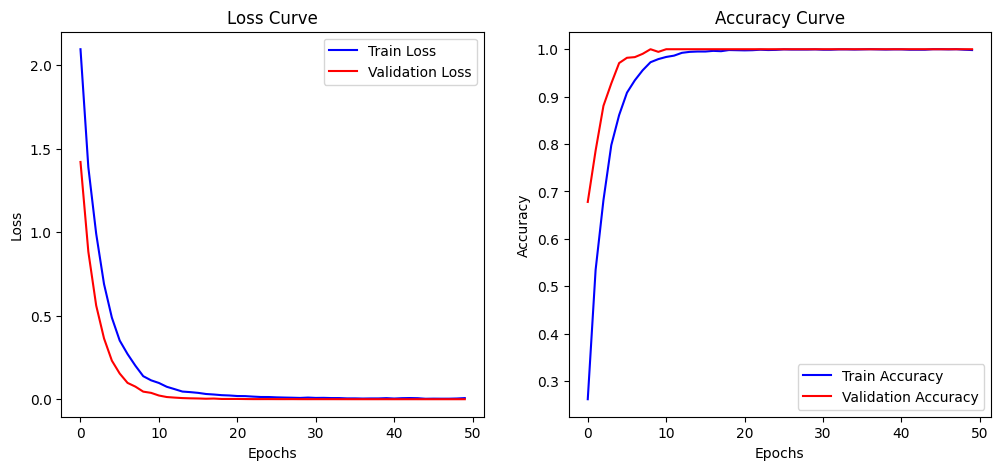

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Train Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

In [12]:
# Evaluate on Train Data
train_results = modelvgg.evaluate(X_train, Y_train, verbose=1)
train_loss, train_acc, train_auc = train_results  # Unpacking 3 values

# Evaluate on Test Data
test_results = modelvgg.evaluate(X_test, Y_test, verbose=1)
test_loss, test_acc, test_auc = test_results  # Unpacking 3 values

# Print Results
print(f"✅ Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.0864e-05
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.4272e-05
✅ Train Loss: 0.0000, Train Accuracy: 1.0000, Train AUC: 1.0000
✅ Test Loss: 0.0000, Test Accuracy: 1.0000, Test AUC: 1.0000


In [13]:
train_results = modelvgg.evaluate(X_train, Y_train, verbose=1)
print(f"Train Results: {train_results}")  

test_results = modelvgg.evaluate(X_test, Y_test, verbose=1)
print(f"Test Results: {test_results}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.0864e-05
Train Results: [2.976819268951658e-05, 1.0, 1.0]
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.4272e-05
Test Results: [4.828053715755232e-05, 1.0, 1.0]


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


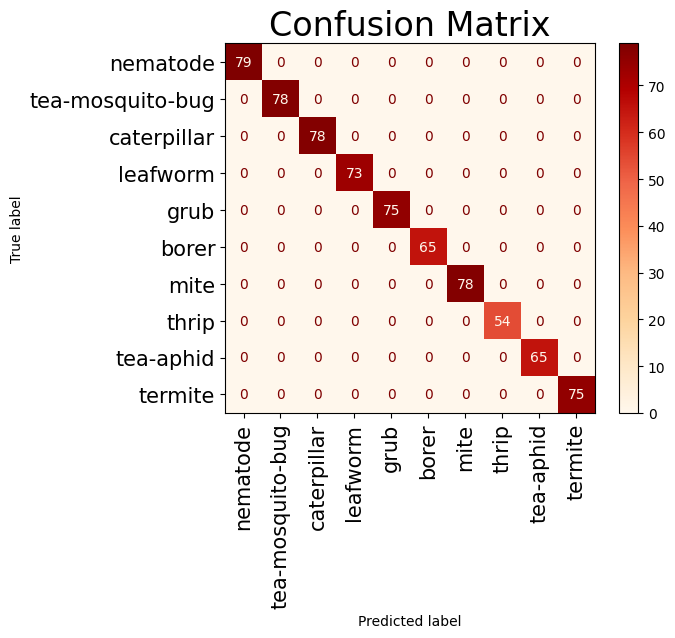

Classification Report:
                   precision    recall  f1-score   support

        nematode       1.00      1.00      1.00        79
tea-mosquito-bug       1.00      1.00      1.00        78
     caterpillar       1.00      1.00      1.00        78
        leafworm       1.00      1.00      1.00        73
            grub       1.00      1.00      1.00        75
           borer       1.00      1.00      1.00        65
            mite       1.00      1.00      1.00        78
           thrip       1.00      1.00      1.00        54
       tea-aphid       1.00      1.00      1.00        65
         termite       1.00      1.00      1.00        75

        accuracy                           1.00       720
       macro avg       1.00      1.00      1.00       720
    weighted avg       1.00      1.00      1.00       720



In [14]:
predictions = modelvgg.predict(X_test, verbose=1)  
y_pred = np.argmax(predictions, axis=1)  
y_test = np.argmax(Y_test, axis=1) 

cm = confusion_matrix(y_test, y_pred)

display_cm = ConfusionMatrixDisplay(cm, display_labels=labels)
display_cm.plot(cmap='OrRd', xticks_rotation=90)  # Proper method call

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))

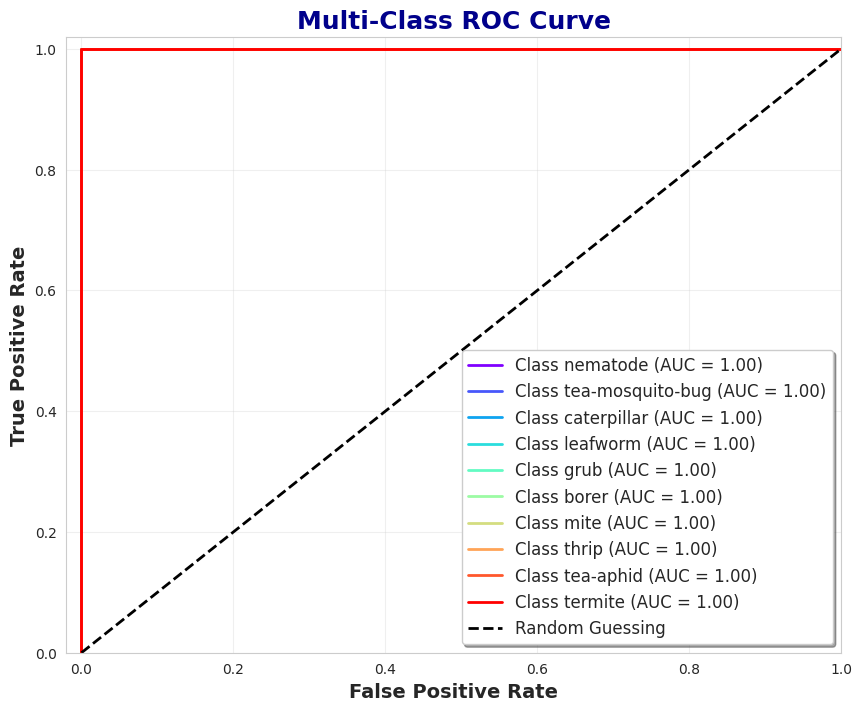

In [15]:
n_classes = Y_test.shape[1]

fpr = {} 
tpr = {}  
roc_auc = {} 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
cmap = get_cmap("rainbow", n_classes)  

for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], color=cmap(i / n_classes), lw=2,
        label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")


plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Multi-Class ROC Curve', fontsize=18, fontweight='bold', color="darkblue")

# Add legend and grid
plt.legend(loc="lower right", fontsize=12, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Save and show plot
plt.savefig("Enhanced_ROC_Curve.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [16]:
modelvgg.save("vgg16_classifier.h5")

In [17]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/vgg16_classifier.h5")

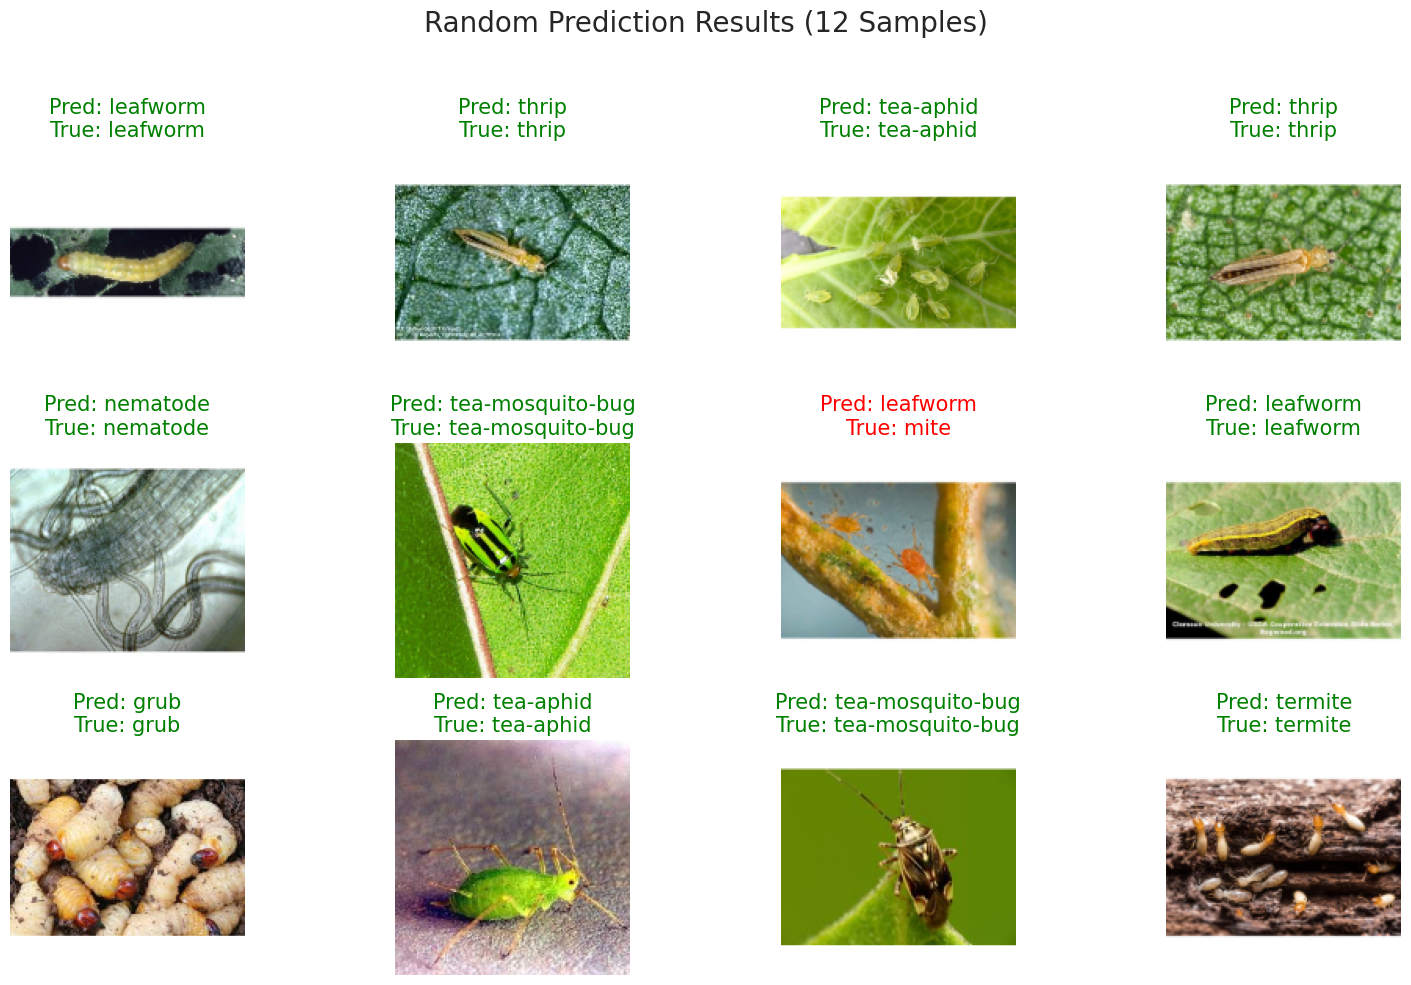

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing import image

# --- Configuration ---
test_dir = "/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test"   # Update to your actual test path
img_size = (150, 150)       # Change based on your model input
class_names = ['nematode', 'tea-mosquito-bug', 'caterpillar', 'leafworm', 'grub', 'borer', 'mite', 'thrip', 'tea-aphid', 'termite']  # Your classes

# --- Collect all test image paths with true labels ---
all_test_images = []
for cls in class_names:
    cls_path = os.path.join(test_dir, cls)
    files = os.listdir(cls_path)
    for fname in files:
        all_test_images.append((os.path.join(cls_path, fname), cls))

# --- Randomly sample 12 images ---
sampled = random.sample(all_test_images, 12)

sample_images = []
true_labels = []
predicted_labels = []

for img_path, true_label in sampled:
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    sample_images.append(img_array)
    true_labels.append(true_label)
    
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
    predicted_labels.append(class_names[np.argmax(pred)])

# --- Display images ---
plt.figure(figsize=(16, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    pred_label = predicted_labels[i]
    true_label = true_labels[i]
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=15, color=color)
    ax.axis("off")

plt.suptitle("Random Prediction Results (12 Samples)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [19]:
def predict(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_expanded, verbose=0)[0]
    predicted_class = class_names[np.argmax(prediction)]

    true_class = None
    for cls in class_names:
        if cls in img_path:
            true_class = cls
            break

    # Display image
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}", color='green' if predicted_class == true_class else 'red')
    plt.axis('off')

    # Probability bar chart
    plt.subplot(1, 2, 2)
    sorted_indices = np.argsort(prediction)[::-1]
    sorted_probs = prediction[sorted_indices]
    sorted_classes = [class_names[i] for i in sorted_indices]

    bars = plt.barh(range(len(sorted_classes)), sorted_probs, color='skyblue')
    plt.yticks(range(len(sorted_classes)), sorted_classes)
    plt.gca().invert_yaxis()
    plt.title("Class Probabilities")

    # Highlight predicted
    bars[0].set_color('orange')

    plt.tight_layout()
    plt.show()

def predict_random():
    import matplotlib.pyplot as plt
    import numpy as np
    from tensorflow.keras.preprocessing import image

    # Choose a random image and true label
    img_path, true_class = random.choice(all_test_images)

    # Load and preprocess
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_expanded, verbose=0)[0]
    predicted_class = class_names[np.argmax(prediction)]

    # Display the image
    plt.figure(figsize=(12, 5))

    # Subplot 1: Image with prediction
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}",
              color='green' if predicted_class == true_class else 'red')
    plt.axis('off')

    # Subplot 2: Probabilities
    sorted_indices = np.argsort(prediction)[::-1]
    sorted_probs = prediction[sorted_indices]
    sorted_classes = [class_names[i] for i in sorted_indices]

    plt.subplot(1, 2, 2)
    bars = plt.barh(range(len(sorted_classes)), sorted_probs, color='skyblue')
    plt.yticks(range(len(sorted_classes)), sorted_classes)
    plt.xlabel("Probability")
    plt.title("Prediction Probabilities")
    plt.gca().invert_yaxis()
    bars[0].set_color('orange')  # Top prediction

    plt.tight_layout()
    plt.show()

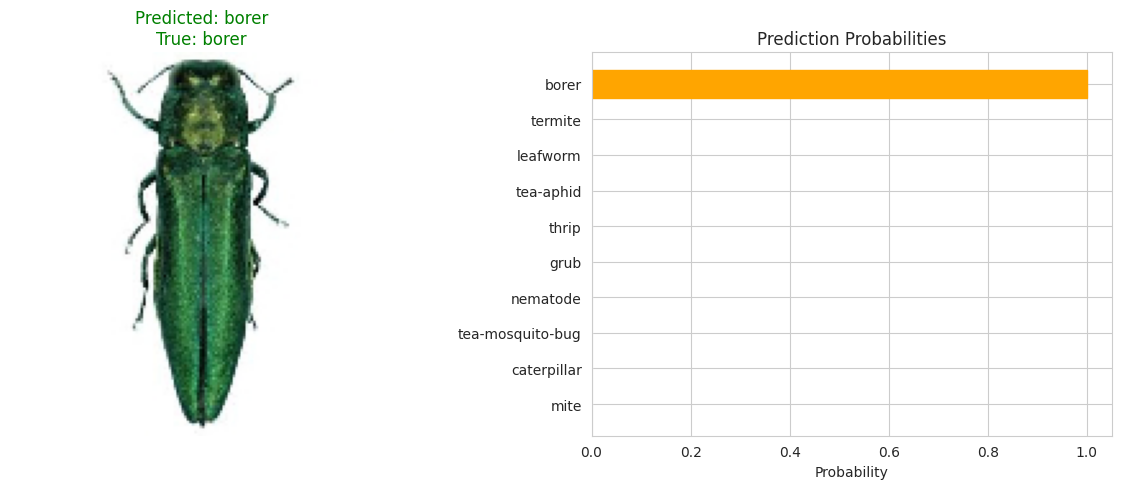

In [20]:
predict_random()

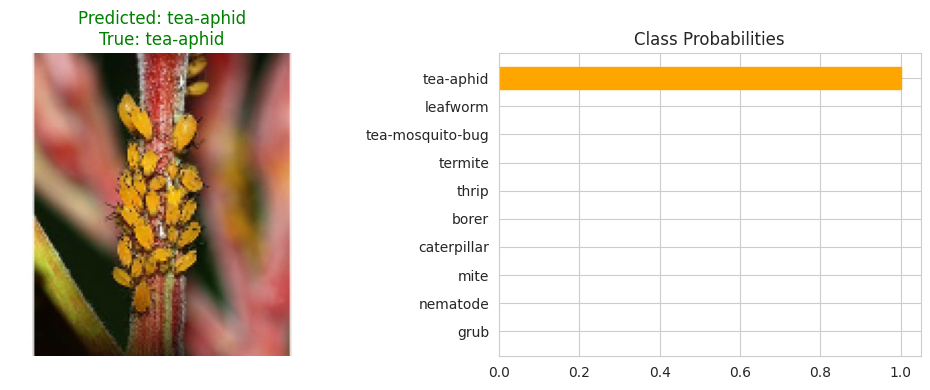

In [21]:
predict("/kaggle/input/tea-leaves-pest-dataset/TeaLeavesPest-Dataset/pest/test/tea-aphid/tea-aphid_03.jpg")